<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Final_Project_100k_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Install Essential Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import pandas as pd
import torch
import seaborn as sn
sn.set()

In [3]:
geners = np.array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
                   'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'], dtype=str)

values = list(range(0, len(geners)))
geners2vec = dict(zip(geners, values))

def extract_geners(text, sep='|'):
  return text.split(sep)

def geners2vector(df_geners, maper):
  result = np.zeros((len(df_geners),len(maper)), dtype='int8')
  for index, text in enumerate(df_geners):
    geners = extract_geners(text)
    for gener in geners:
      result[index][maper.get(gener)] = 1
  
  return result

In [4]:
def year_extractor(text):
  return text[text.rfind('(')+1:text.rfind(')')]

def calculate_average_rating(rating_df, movies_df, Movie_id_col='MovieID', rating_col='Rating'):
  
  rating_avg = rating_df.groupby(Movie_id_col).mean()[rating_col].round(4).to_dict()
  result = [] 
  for id in movies_df[Movie_id_col]:
    result.append(rating_avg.get(id, 0))
  movies_df['Average Rating'] = result
  return movies_df

Occupation_mapper = { 0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                     4: "college/grad student",5: "customer service", 6: "doctor/health care",
                     7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
                     11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
                     15: "scientist", 16: "self-employed", 17: "technician/engineer",
                     18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

def code2Occupation(occupation_col, mapper):
  return occupation_col.map(mapper)


def extract_user_feature(users_df):
  scaler = StandardScaler()
  age = scaler.fit_transform(users_df[['Age']])
  
  encoder = OneHotEncoder(handle_unknown='ignore')
  occupation = encoder.fit_transform(users_df[['Occupation']]).toarray()
  features = np.hstack((users_df[['Gender']], age, occupation))
  return torch.from_numpy(features).to(torch.float)

def extract_movie_feature(movies_df, mapper):
  scaler = StandardScaler()
  numerical = scaler.fit_transform(movies_df[['year',	'averge_rating']])
  
  categorical = geners2vector(movies_df['Genres'], mapper)
  features = np.hstack((numerical, categorical))
  return torch.from_numpy(features).to(torch.float)

def Timestamp2Date(timestamp):
  return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

def add_age_group(df, age_col='Age'):
  bins= [0,20,25,39,60,110]
  labels = ['Teenage','Young Adult','Adult', 'Older Adult','Old']
  df['AgeGroup'] = pd.cut(df[age_col], bins=bins, labels=labels, right=False)
  return df

## Read the Dataset

In [ ]:
# movies_df = pd.read_csv('/content/ml-100k/u.item', sep='|', engine='python', encoding="latin-1",
#                         names = ['MovieID', 'Movie Title', 'Release Date', 'video release date','IMDbURL',
#                                  'Unknown','Action','Adventure','Animation', 'Childrens','Comedy',
#                                  'Crime','Documentary','Drama','Fantasy', 'Film-Noir','Horror',
#                                  'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

# rating_df = pd.read_csv('/content/ml-100k/u.data', sep='\t', engine='python', encoding="latin-1",
#                         names=['UserID','MovieID','Rating','Timestamp'])

# users_df = pd.read_csv('/content/ml-100k/u.user', sep='|', engine='python', encoding="latin-1",
#                        names=['UserID','Age', 'Gender', 'Occupation','Zipcode'])

# movies_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv', index=False)
# rating_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv', index=False)
# users_df.to_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv', index=False)

In [5]:
movies_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/movies_df.csv')
rating_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/rating_df.csv')
users_df = pd.read_csv('/content/gdrive/MyDrive/MLG_Final_Project/MovieLens100k/Data/users_df.csv')
movies_df.shape, rating_df.shape, users_df.shape


((1682, 24), (100000, 4), (943, 5))

In [6]:
rating_df

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [7]:
def remove_movies(rating_df, movies_df, title_col='Movie Title', movie_id_col='MovieID'):
  unknown_movies = movies_df[movies_df[title_col]=='unknown'][movie_id_col]
  rating_df = rating_df[~rating_df[movie_id_col].isin(unknown_movies)]
  movies_df = movies_df[~movies_df[movie_id_col].isin(unknown_movies)]
  return rating_df, movies_df

rating_df, movies_df = remove_movies(rating_df, movies_df)


In [8]:
movies_df.drop(['video release date', 'IMDbURL'], axis=1, inplace=True)
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])
movies_df['Release Year'] = movies_df['Release Date'].dt.year
movies_df['Release Month'] = movies_df['Release Date'].dt.month
movies_df = movies_df.sort_values(by=['Release Date']).reset_index(drop=True)
movies_df = calculate_average_rating(rating_df, movies_df)
movies_df.tail(2).T

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-8-ddf3551ec234>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])
<ipython-input-8-ddf3551ec234>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,1679,1680
MovieID,1432,315
Movie Title,"Mighty, The (1998)",Apt Pupil (1998)
Release Date,1998-10-09 00:00:00,1998-10-23 00:00:00
Unknown,0,0
Action,0,0
Adventure,0,0
Animation,0,0
Childrens,0,0
Comedy,0,0
Crime,0,0


In [9]:
users_df = add_age_group(users_df)
users_df

,UserID,Age,Gender,Occupation,Zipcode,AgeGroup
0,1,24,M,technician,85711,Young Adult
1,2,53,F,other,94043,Older Adult
2,3,23,M,writer,32067,Young Adult
3,4,24,M,technician,43537,Young Adult
4,5,33,F,other,15213,Adult
...,...,...,...,...,...,...
938,939,26,F,student,33319,Adult
939,940,32,M,administrator,02215,Adult
940,941,20,M,student,97229,Young Adult
941,942,48,F,librarian,78209,Older Adult


In [10]:
rating_df.loc[:,'Timestamp'] = rating_df.loc[:,'Timestamp'].apply(Timestamp2Date)
rating_df.sort_values(by= 'Timestamp', inplace=True)
rating_df.reset_index(drop=True, inplace=True)
rating_df

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,UserID,MovieID,Rating,Timestamp
0,259,255,4,1997-09-20 03:05:10
1,259,286,4,1997-09-20 03:05:27
2,259,298,4,1997-09-20 03:05:54
3,259,185,4,1997-09-20 03:06:21
4,259,173,4,1997-09-20 03:07:23
...,...,...,...,...
99986,729,689,4,1998-04-22 23:10:38
99987,729,300,4,1998-04-22 23:10:38
99988,729,748,4,1998-04-22 23:10:38
99989,729,313,3,1998-04-22 23:10:38


# Exploratory Data-Analysis

## Users Analysis

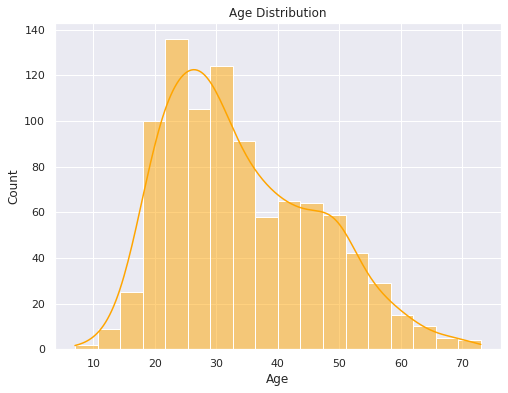

In [11]:
plt.figure(figsize=(8,6))
plt.title('Age Distribution')
sn.histplot(data=users_df, x="Age", color='orange', kde=True, alpha=0.5)

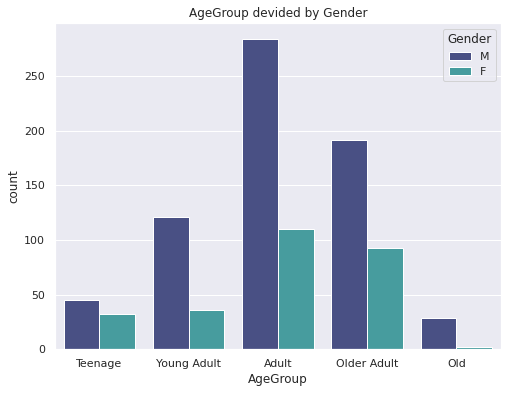

In [12]:
plt.figure(figsize=(8,6))
plt.title('AgeGroup devided by Gender')
sn.countplot(data=users_df, x='AgeGroup', hue='Gender', palette='mako')

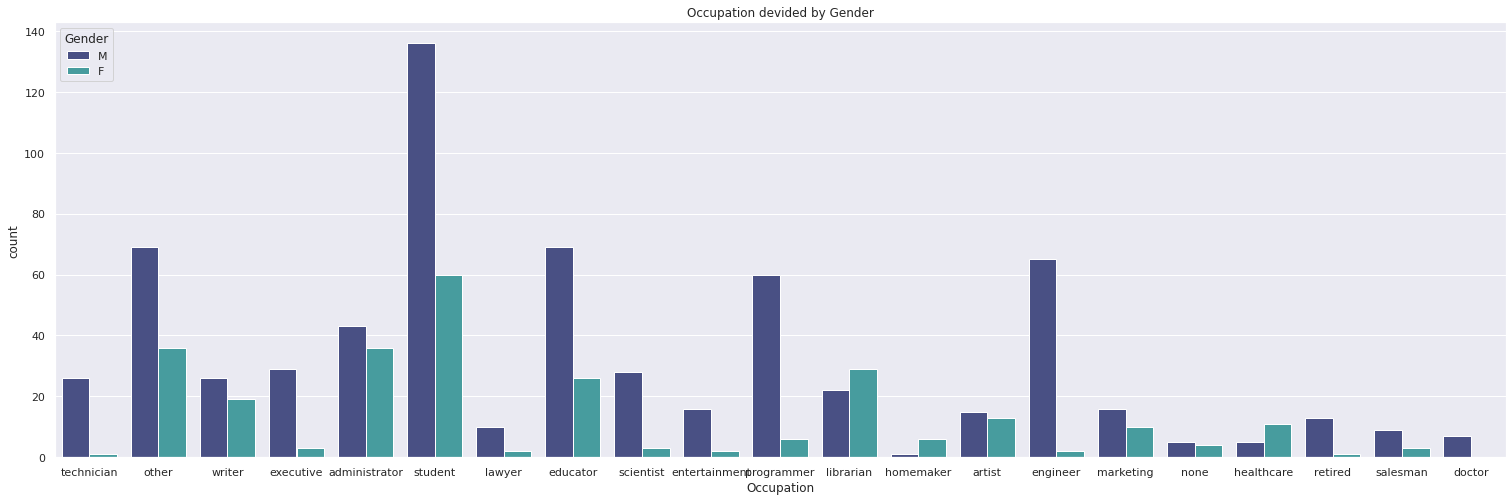

In [13]:
plt.figure(figsize=(26,8))
plt.title('Occupation devided by Gender')
sn.countplot(data=users_df, x='Occupation', hue='Gender', palette='mako')

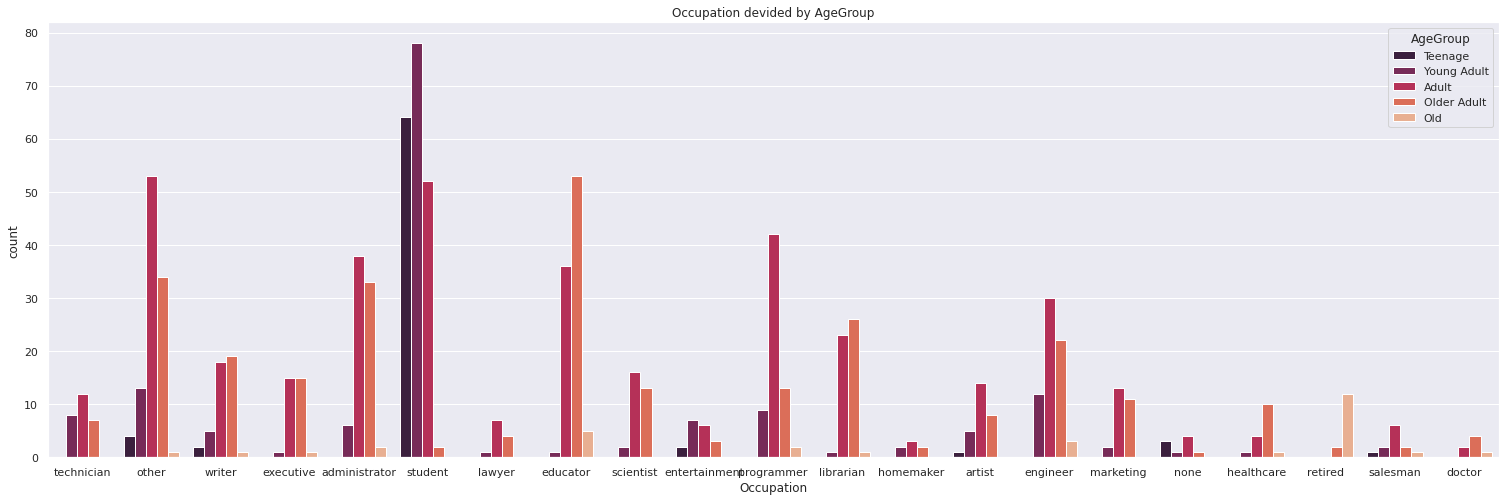

In [14]:
plt.figure(figsize=(26,8))
plt.title('Occupation devided by AgeGroup')
sn.countplot(data=users_df, x='Occupation', hue='AgeGroup', palette='rocket')

## Movies Analysis

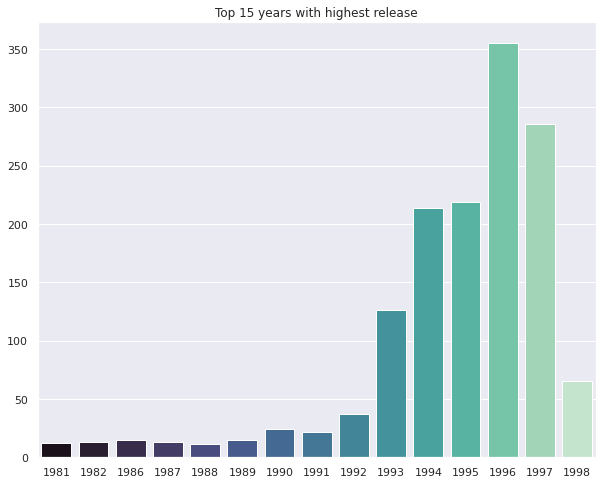

In [15]:
x = movies_df['Release Year'].value_counts()[:15]

plt.figure(figsize=(10,8))
plt.title('Top 15 years with highest release')
sn.barplot(x=x.index, y=x.values, palette='mako')

In [16]:
movies_df

,MovieID,Movie Title,Release Date,Unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Release Year,Release Month,Average Rating
0,675,"Nosferatu (Nosferatu, eine Symphonie des Graue...",1922-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1922,1,3.5556
1,1542,"Scarlet Letter, The (1926)",1926-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1926,1,3.0000
2,617,"Blue Angel, The (Blaue Engel, Der) (1930)",1930-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1930,1,3.7778
3,656,M (1931),1931-01-01,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1931,1,4.0000
4,1124,"Farewell to Arms, A (1932)",1932-01-01,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1932,1,3.8333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1651,"Spanish Prisoner, The (1997)",1998-03-27,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1998,3,4.0000
1677,1649,"Big One, The (1997)",1998-03-27,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1998,3,3.0000
1678,918,City of Angels (1998),1998-04-03,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1998,4,3.0000
1679,1432,"Mighty, The (1998)",1998-10-09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,10,1.0000


In [17]:
highest_Ratings = pd.DataFrame(movies_df.set_index('MovieID').groupby(['Release Year'])['Average Rating'].nlargest(3))
highest_Ratings.style.background_gradient(cmap=sn.color_palette("ch:s=-.2,r=.6", as_cmap=True))

In [18]:
lowest_Ratings = pd.DataFrame(movies_df.set_index('MovieID').groupby(['Release Year'])['Average Rating'].nsmallest(3))
lowest_Ratings.style.background_gradient(cmap=sn.light_palette("seagreen", as_cmap=True))

In [19]:
top_k = 5
genres  = np.array(['Action','Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime',
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror','Musical',
                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western'],
      dtype=object)

def genres_info(movies_df, genres, top_k=5):
  highest = np.zeros(shape=(len(genres)*top_k, 4), dtype=object)
  lowest = np.zeros(shape=(len(genres)*top_k, 4),  dtype=object)
  avg_rating = np.zeros(len(genres))
  for i, genre in enumerate(genres):
    df = movies_df[movies_df[genre]==1][['Movie Title', 'MovieID', genre,'Average Rating']]
    avg_rating[i]= df['Average Rating'].mean()
    df[genre]=genre
    high = df.sort_values(by='Average Rating', ascending=False).reset_index(drop=True).iloc[:top_k,:].to_numpy()
    low = df.sort_values(by='Average Rating', ascending=True).reset_index(drop=True).iloc[:top_k,:].to_numpy()
    
    start, end = i*top_k, (i+1)*top_k
    highest[start:end] = high
    lowest[start:end] = low
  return highest, lowest, avg_rating


highest, lowest, avg_rating = genres_info(movies_df, genres)
highest_df = pd.DataFrame(highest, columns=['Movie Title', 'MovieID','Genre','Average Rating'])
highest_df['Average Rating'] = highest_df['Average Rating'].astype(float)
lowest_df = pd.DataFrame(lowest, columns=['Movie Title', 'MovieID','Genre','Average Rating'])
lowest_df['Average Rating'] = lowest_df['Average Rating'].astype(float)
avg_rating_df = pd.DataFrame(avg_rating, index=genres, columns=['Average Rating'])

In [20]:
highest_rating_df = pd.DataFrame(highest_df.groupby(['Genre','Movie Title'])['Average Rating'].mean())
highest_rating_df.style.background_gradient(cmap=sn.color_palette("ch:s=-.2,r=.6", as_cmap=True))

In [21]:
lowest_rating_df = pd.DataFrame(lowest_df.groupby(['Genre','Movie Title'])['Average Rating'].mean())
lowest_rating_df.style.background_gradient(cmap=sn.light_palette("seagreen", as_cmap=True))

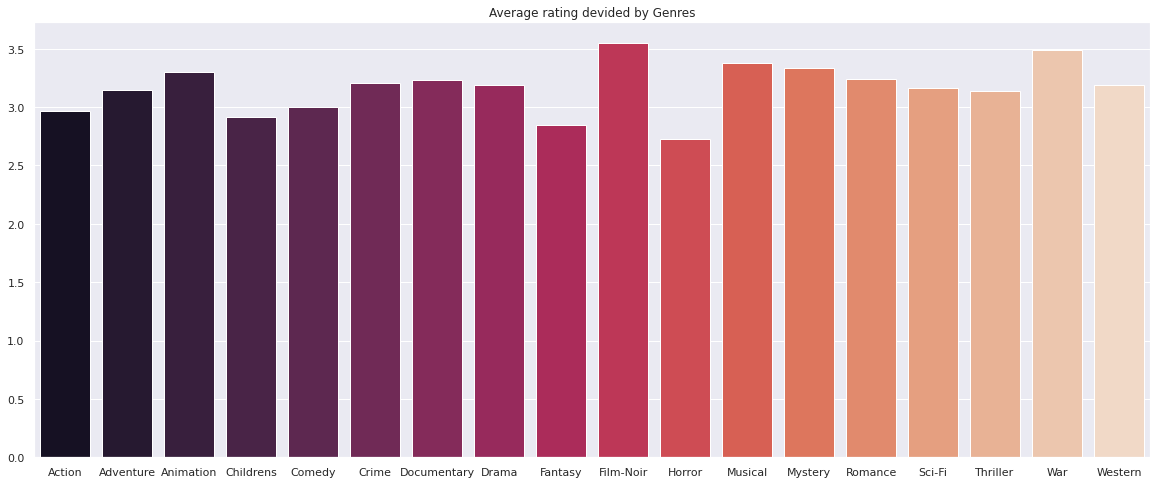

In [22]:
plt.figure(figsize=(20,8))
plt.title('Average rating devided by Genres')
sn.barplot(x=genres, y=avg_rating, palette='rocket')

## Rating Analysis

In [23]:
rating_df

,UserID,MovieID,Rating,Timestamp
0,259,255,4,1997-09-20 03:05:10
1,259,286,4,1997-09-20 03:05:27
2,259,298,4,1997-09-20 03:05:54
3,259,185,4,1997-09-20 03:06:21
4,259,173,4,1997-09-20 03:07:23
...,...,...,...,...
99986,729,689,4,1998-04-22 23:10:38
99987,729,300,4,1998-04-22 23:10:38
99988,729,748,4,1998-04-22 23:10:38
99989,729,313,3,1998-04-22 23:10:38


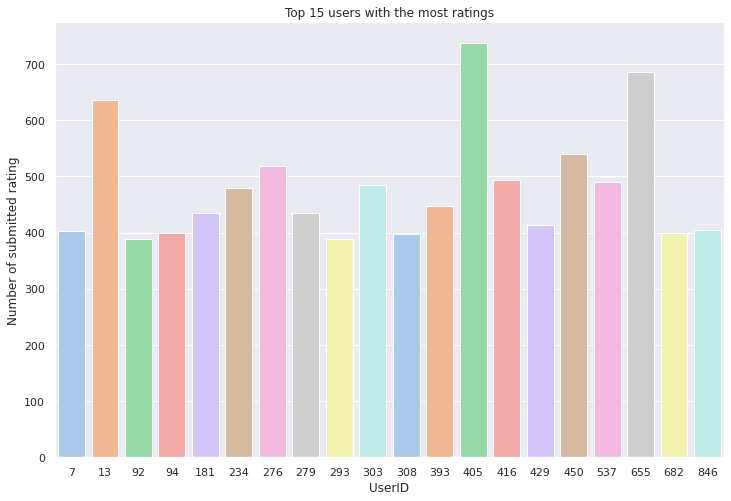

In [24]:
x = rating_df['UserID'].value_counts()[:20]

plt.figure(figsize=(12,8))
plt.title('Top 15 users with the most ratings')
plt.xlabel('UserID')
plt.ylabel('Number of submitted rating')
sn.barplot(x=x.index, y=x.values, palette='pastel')

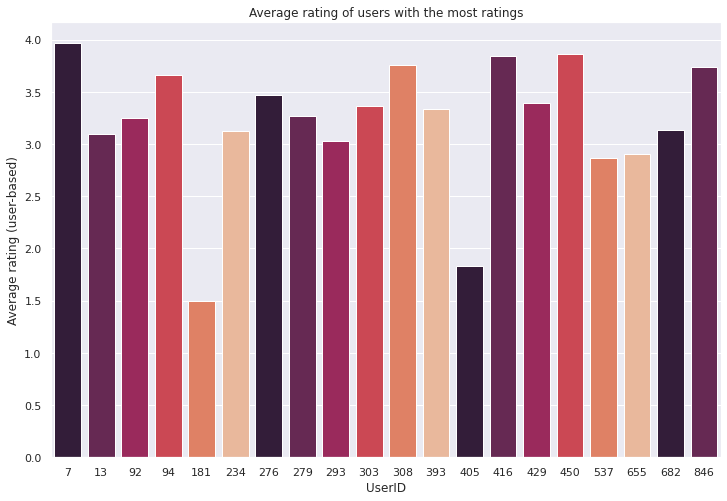

In [25]:
x = rating_df['UserID'].value_counts()[:20]
common_avg_rating = rating_df[rating_df['UserID'].isin(x.index)].groupby('UserID')['Rating'].mean().sort_values()
plt.figure(figsize=(12,8))
plt.title('Average rating of users with the most ratings')
plt.xlabel('UserID')
plt.ylabel('Average rating (user-based)')
sn.barplot(x=common_avg_rating.index, y=common_avg_rating.values, palette=sn.color_palette("rocket"))

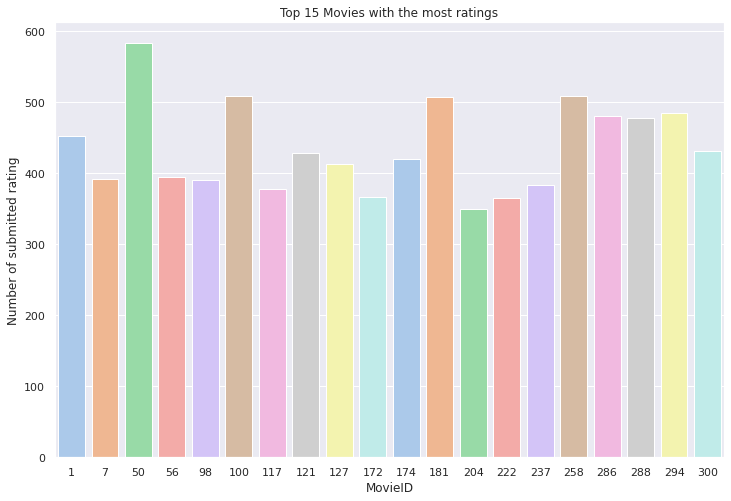

In [26]:
x = rating_df['MovieID'].value_counts()[:20]

plt.figure(figsize=(12,8))
plt.title('Top 15 Movies with the most ratings')
plt.xlabel('MovieID')
plt.ylabel('Number of submitted rating')
sn.barplot(x=x.index, y=x.values, palette='pastel')

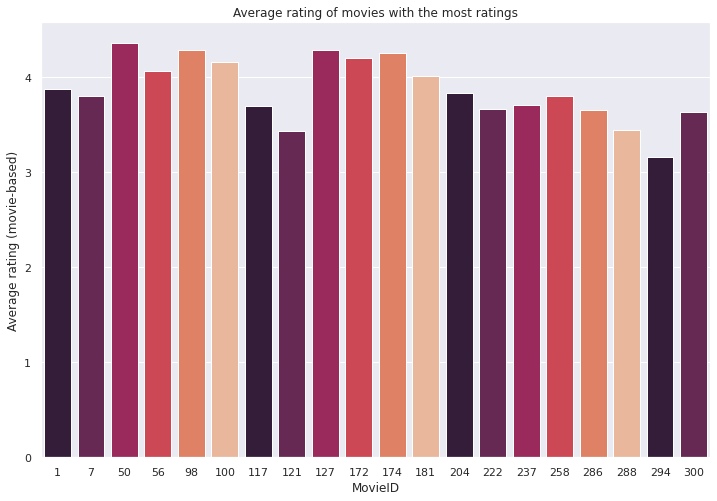

In [27]:
x = rating_df['MovieID'].value_counts()[:20]
common_avg_rating = rating_df[rating_df['MovieID'].isin(x.index)].groupby('MovieID')['Rating'].mean().sort_values()
plt.figure(figsize=(12,8))
plt.title('Average rating of movies with the most ratings')
plt.xlabel('MovieID')
plt.ylabel('Average rating (movie-based)')
sn.barplot(x=common_avg_rating.index, y=common_avg_rating.values, palette=sn.color_palette("rocket"))

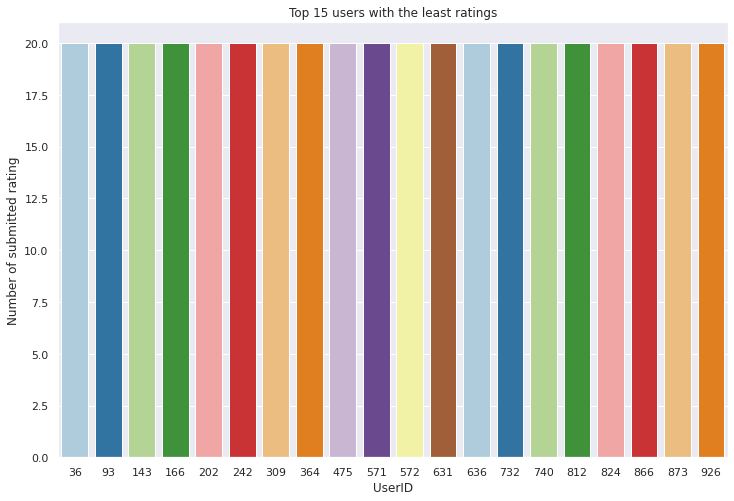

In [28]:
x = rating_df['UserID'].value_counts()[-20:]

plt.figure(figsize=(12,8))
plt.title('Top 15 users with the least ratings')
plt.xlabel('UserID')
plt.ylabel('Number of submitted rating')
sn.barplot(x=x.index, y=x.values, palette=sn.color_palette("Paired"))

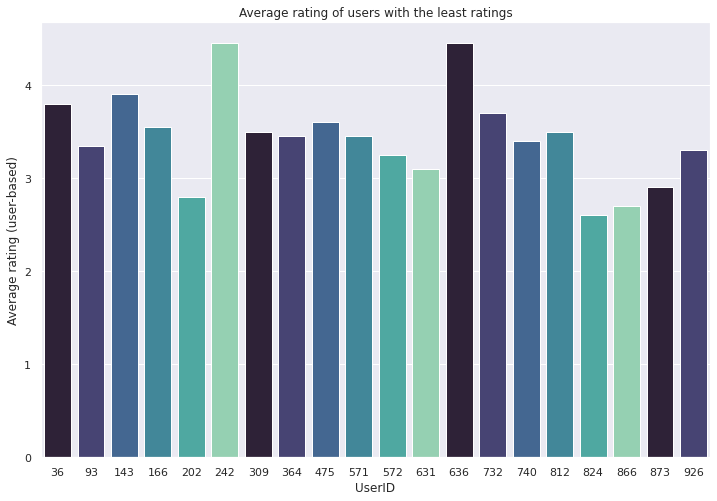

In [29]:
x = rating_df['UserID'].value_counts()[-20:]
common_avg_rating = rating_df[rating_df['UserID'].isin(x.index)].groupby('UserID')['Rating'].mean().sort_values()
plt.figure(figsize=(12,8))
plt.title('Average rating of users with the least ratings')
plt.xlabel('UserID')
plt.ylabel('Average rating (user-based)')
sn.barplot(x=common_avg_rating.index, y=common_avg_rating.values, palette=sn.color_palette("mako"))

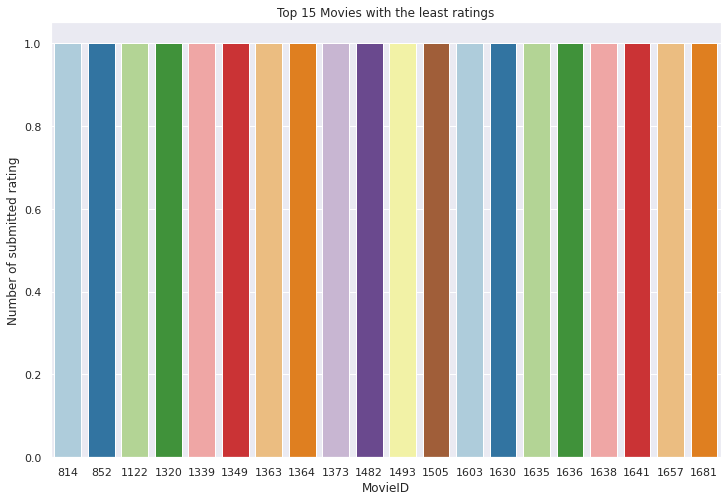

In [30]:
x = rating_df['MovieID'].value_counts()[-20:]

plt.figure(figsize=(12,8))
plt.title('Top 15 Movies with the least ratings')
plt.xlabel('MovieID')
plt.ylabel('Number of submitted rating')
sn.barplot(x=x.index, y=x.values, palette=sn.color_palette("Paired"))

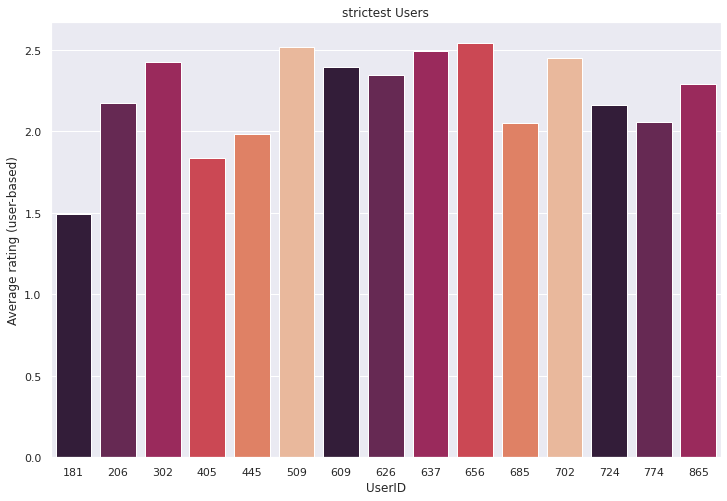

In [31]:
avg_rating_user = rating_df.groupby('UserID')['Rating'].mean().sort_values()

plt.figure(figsize=(12,8))
plt.title('strictest Users')
plt.xlabel('UserID')
plt.ylabel('Average rating (user-based)')
sn.barplot(x=avg_rating_user[:15].index, y=avg_rating_user[:15].values, palette=sn.color_palette("rocket"))

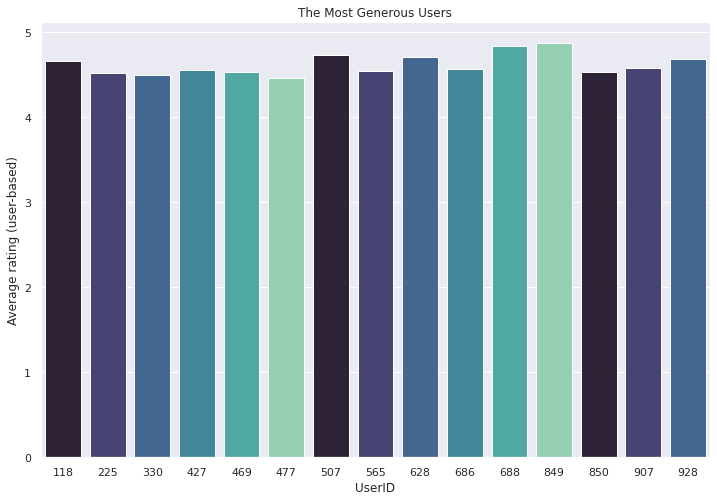

In [32]:
plt.figure(figsize=(12,8))
plt.title('The Most Generous Users')
plt.xlabel('UserID')
plt.ylabel('Average rating (user-based)')
sn.barplot(x=avg_rating_user[-15:].index, y=avg_rating_user[-15:].values, palette=sn.color_palette("mako"))

In [33]:
rating_df.loc[:,'Timestamp'] = pd.to_datetime(rating_df.loc[:,'Timestamp'])
rating_df.loc[:,'Time_Year'] = rating_df.loc[:,'Timestamp'].dt.year
rating_df.loc[:,'Time_Month'] = rating_df.loc[:,'Timestamp'].dt.strftime('%B')
rating_df.loc[:,'Time_Weekday'] = rating_df.loc[:,'Timestamp'].dt.strftime('%A')
rating_df.loc[:,'Time_Hour'] = rating_df.loc[:,'Timestamp'].dt.hour
rating_df.loc[:,'Time_DayofYear'] = rating_df.loc[:,'Timestamp'].dt.strftime('%j')
rating_df

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,UserID,MovieID,Rating,Timestamp,Time_Year,Time_Month,Time_Weekday,Time_Hour,Time_DayofYear
0,259,255,4,1997-09-20 03:05:10,1997,September,Saturday,3,263
1,259,286,4,1997-09-20 03:05:27,1997,September,Saturday,3,263
2,259,298,4,1997-09-20 03:05:54,1997,September,Saturday,3,263
3,259,185,4,1997-09-20 03:06:21,1997,September,Saturday,3,263
4,259,173,4,1997-09-20 03:07:23,1997,September,Saturday,3,263
...,...,...,...,...,...,...,...,...,...
99986,729,689,4,1998-04-22 23:10:38,1998,April,Wednesday,23,112
99987,729,300,4,1998-04-22 23:10:38,1998,April,Wednesday,23,112
99988,729,748,4,1998-04-22 23:10:38,1998,April,Wednesday,23,112
99989,729,313,3,1998-04-22 23:10:38,1998,April,Wednesday,23,112


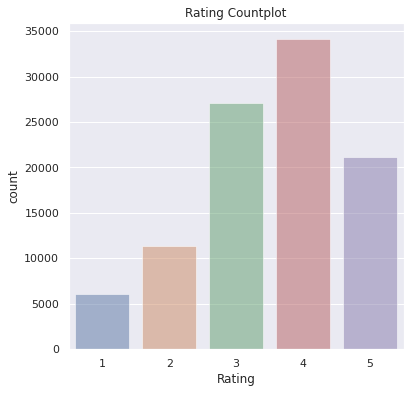

In [41]:
plt.figure(figsize=(6,6))
plt.title('Rating Countplot')
sn.countplot(data=rating_df, x="Rating", alpha=0.5)

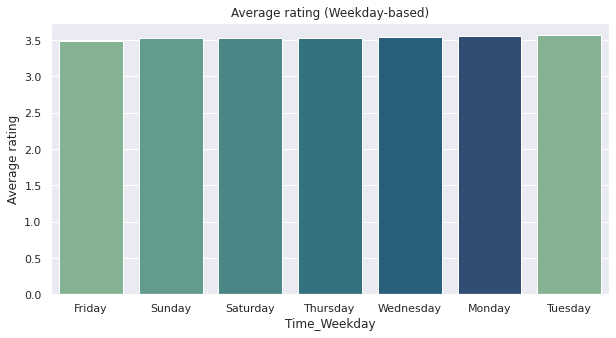

In [ ]:
avg_rating_Weekday = rating_df.groupby('Time_Weekday')['Rating'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.title('Average rating (Weekday-based)')
plt.xlabel('Weekday')
plt.ylabel('Average rating')
sn.barplot(x=avg_rating_Weekday.index, y=avg_rating_Weekday.values, palette=sn.color_palette("crest"))

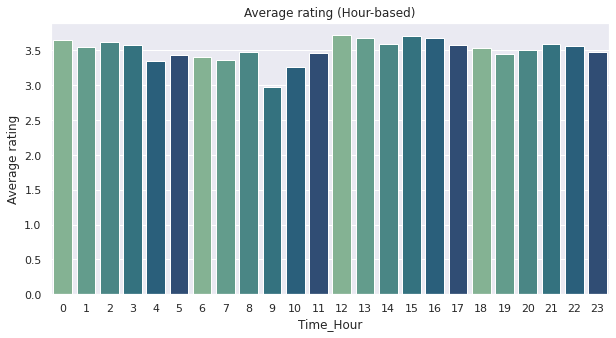

In [ ]:
avg_rating_Weekday = rating_df.groupby('Time_Hour')['Rating'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.title('Average rating (Hour-based)')
plt.xlabel('Hour')
plt.ylabel('Average rating')
sn.barplot(x=avg_rating_Weekday.index, y=avg_rating_Weekday.values, palette=sn.color_palette("crest"))

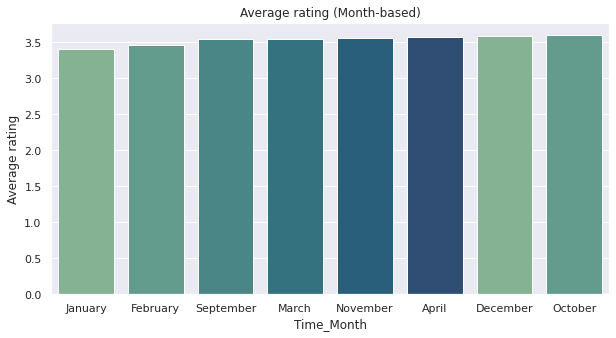

In [ ]:
avg_rating_Weekday = rating_df.groupby('Time_Month')['Rating'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.title('Average rating (Month-based)')
plt.xlabel('Month')
plt.ylabel('Average rating')
sn.barplot(x=avg_rating_Weekday.index, y=avg_rating_Weekday.values, palette=sn.color_palette("crest"))

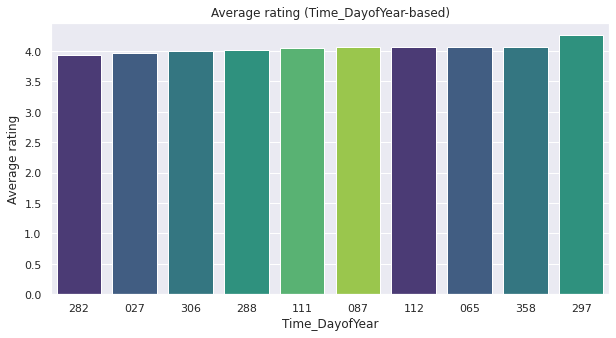

In [ ]:
avg_rating_Weekday = rating_df.groupby('Time_DayofYear')['Rating'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.title('High Average rating (DayofYear-based)')
plt.xlabel('DayofYear')
plt.ylabel('Average rating')
sn.barplot(x=avg_rating_Weekday[-10:].index, y=avg_rating_Weekday[-10:].values, palette=sn.color_palette("crest"))

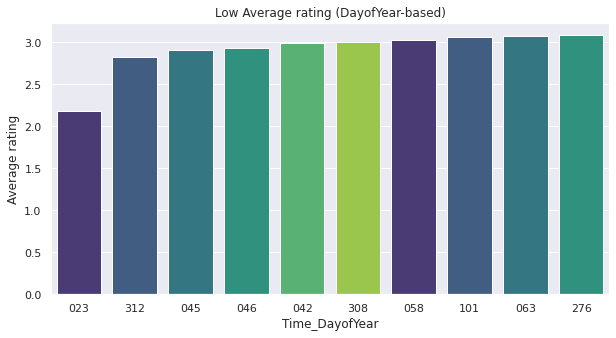

In [ ]:
avg_rating_Weekday = rating_df.groupby('Time_DayofYear')['Rating'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.title('Low Average rating (DayofYear-based)')
plt.xlabel('DayofYear')
plt.ylabel('Average rating')
sn.barplot(x=avg_rating_Weekday[:10].index, y=avg_rating_Weekday[:10].values, palette=sn.color_palette("crest"))

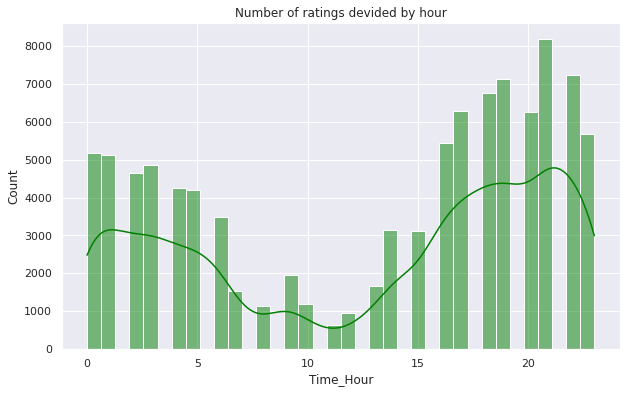

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Number of ratings devided by hour')
sn.histplot(data=rating_df, x='Time_Hour', color='Green', kde=True, alpha=0.5)

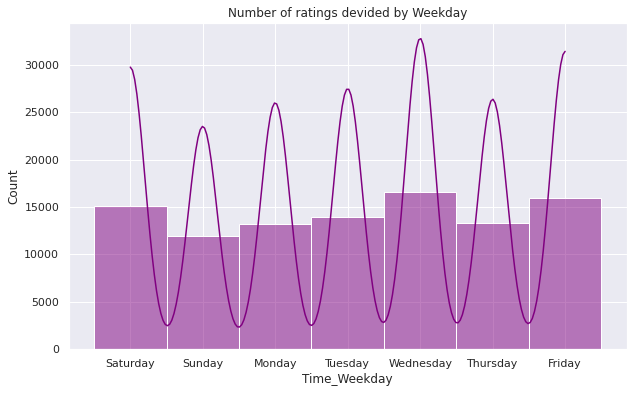

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Number of ratings devided by Weekday')
sn.histplot(data=rating_df, x='Time_Weekday', color='purple', kde=True, alpha=0.5)

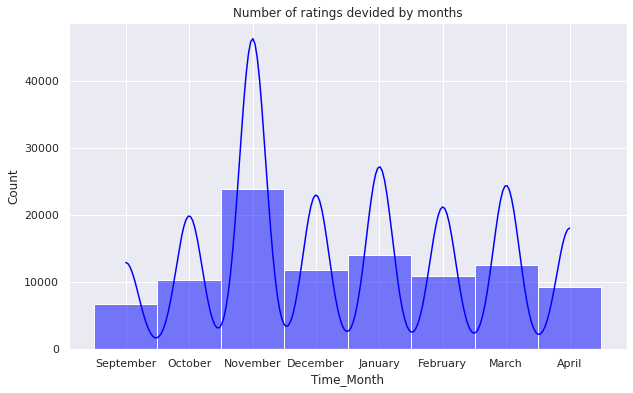

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Number of ratings devided by months')
sn.histplot(data=rating_df, x='Time_Month', color='Blue', kde=True, alpha=0.5)

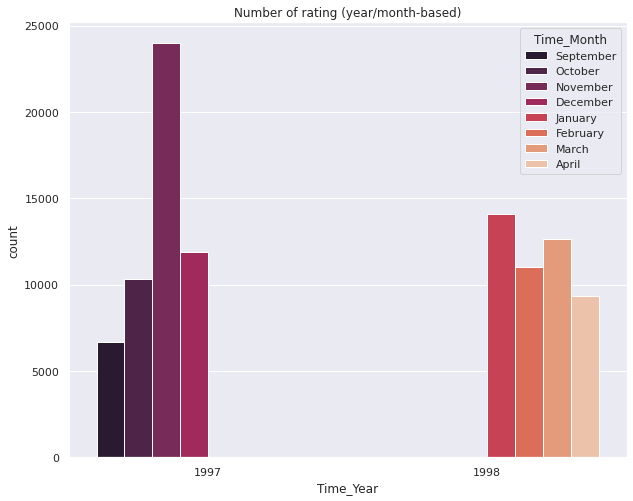

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Number of rating (year/month-based)')
sn.countplot(data=rating_df, x='Time_Year', hue='Time_Month', palette='rocket')

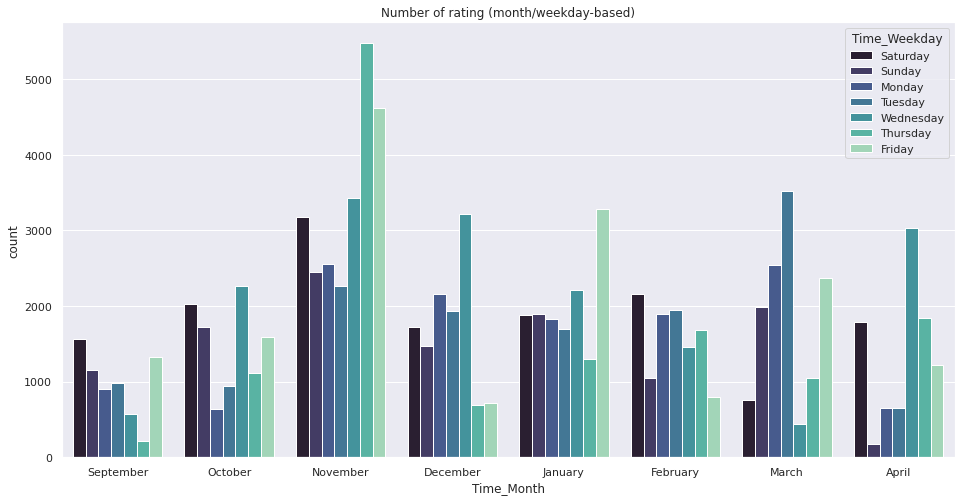

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Number of rating (month/weekday-based)')
sn.countplot(data=rating_df, x='Time_Month', hue='Time_Weekday', palette='mako')